# Dog Breed Classification Using Transfer Learning

### This notebook contains steps taken to apply transfer learning using the pre-trained `resnet50` model.
### The new model has been used to classify dog breeds from dog images as input.
-----------------------------------------------------------------------------------------------------

The tasks completed to perform this training are as follows:

A) Perform hyperparameter tuning to select the best training params for the classification model

B) Use the best training params derived in step A to train a classification model using a pre-trained resnet50 model.
   Apply debugging and profiling hooks to this training job to analyse performance issues.

C) Deploy the model trained on the dogs training dataset to an endpoint

D) Run predictions on the test images using the deployed endpoint in step C

-----------------------------------------------------------------------------------------------------

**NOTE:** An effort was made previously to accomplish the same using a `resnet18` model, but the model could not handle the complexity of the classification problem

-----------------------------------------------------------------------------------------------------
## DOWNLAD & INSTALL REQUIRED DEPENDENCIES
-----------------------------------------------------------------------------------------------------

In [1]:
# Install 
!pip install smdebug
!pip install cloudpathlib
!pip install torch
!pip install torchvision

  Using cached cloudpathlib-0.7.0-py3-none-any.whl (52 kB)


In [2]:
# Import packages
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor



import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import IPython

import numpy as np
import boto3
from cloudpathlib import CloudPath

from PIL import Image
from io import BytesIO


[2022-05-04 04:42:17.337 ip-172-16-42-201:16934 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


-----------------------------------------------------------------------------------------------------
## FETCH & UPLOAD THE DATASET TO AWS S3
-----------------------------------------------------------------------------------------------------

## Dataset
The dog breed classification dataset provided by Udacity has been used here. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

The training folder includes **6680** items

The validation folder includes **835** items

The testing folder includes **836** items

In [ ]:
# Command to download and unzip data

#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip -d dataset/

In [5]:
!pwd

/home/ec2-user/SageMaker


In [6]:
!ls /home/ec2-user/SageMaker/dataset

dogImages


In [ ]:
#!aws s3 cp /home/ec2-user/SageMaker/dataset s3://dog-breed-multiclass-classification --recursive

-----------------------------------------------------------------------------------------------------
## STEP A - HYPERPARAMETER TUNING
-----------------------------------------------------------------------------------------------------


In this part a resnet50 pretrained model has been used to perform hyperparameter tuning - such that it the best hyperparameters are determined for the predictor model. 
The hyperparameters being tuned are:

1) Learning rate    --> Continuous parameter with values tuned between 0.04 and 0,1

2) Batch size       --> Categorical parameter with specific list of trial values

3) Number of epochs --> Integer parameter between 3 and 6(inclusive)

The training and testing script in `hpo.py` is used to perform hyperparameter tuning.

In [37]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.04, 0.1),
    "batch-size": CategoricalParameter([8, 16, 32, 64]),
    "epochs": IntegerParameter(3, 6)
}

# The objective metric to be used by the Hyperparameter Tuning jobs is the Test Accuracy of the model on the validation dataset

objective_metric_name = "Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)%"}]


In [41]:
# Create estimators for HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

# Configuring the estimated to run 6 total hyperparameter tuner jobs with a allowed parallel job count of 2

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:

inputs_train = 's3://dog-breed-multiclass-classification/dogImages/train/'
inputs_test = 's3://dog-breed-multiclass-classification/dogImages/valid/'

tuner.fit({"training": inputs_train,"test":inputs_test})


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [44]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2022-05-04 00:16:58 Starting - Preparing the instances for training
2022-05-04 00:16:58 Downloading - Downloading input data
2022-05-04 00:16:58 Training - Training image download completed. Training in progress.
2022-05-04 00:16:58 Uploading - Uploading generated training model
2022-05-04 00:16:58 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"16"',
 'epochs': '6',
 'lr': '0.07756500209627985',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-05-03-22-19-56-563"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-03-22-19-56-563/source/sourcedir.tar.gz"'}

In [45]:
tuner.best_training_job()

'pytorch-training-220503-2219-003-59bf32c3'

-----------------------------------------------------------------------------------------------------
## STEP B - TRANSFER LEARNING USING BEST HYPERPARAMETERS
-----------------------------------------------------------------------------------------------------



### MODEL PROFILING AND DEBUGGING

Using the best hyperparameters, create and finetune a new model

Using the `train_model.py` script to perform model profiling and debugging.

Using the attach method of the HyperparameterTuner class to retrieve the job details(as I had taken a pause and shutdown the notebook after the tuning job ran)

In [3]:
attach_tuner = HyperparameterTuner.attach("pytorch-training-220503-2219")

In [4]:
attach_tuner.best_estimator().hyperparameters()


2022-05-04 00:16:58 Starting - Preparing the instances for training
2022-05-04 00:16:58 Downloading - Downloading input data
2022-05-04 00:16:58 Training - Training image download completed. Training in progress.
2022-05-04 00:16:58 Uploading - Uploading generated training model
2022-05-04 00:16:58 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"16"',
 'epochs': '6',
 'lr': '0.07756500209627985',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-05-03-22-19-56-563"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-03-22-19-56-563/source/sourcedir.tar.gz"'}

The optimum hyperparameters being determined by the tuning job are:

1) Learning rate    --> 0.07756500209627985

2) Batch size       --> 16

3) Number of epochs --> 6

In [5]:
# Debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"include_regex": "CrossEntropyLoss_output_0","train.save_interval": "100", "eval.save_interval": "10"}
)

In [6]:
debugger_config.hook_parameters

{'include_regex': 'CrossEntropyLoss_output_0',
 'train.save_interval': '100',
 'eval.save_interval': '10'}

In [7]:
hyperparameters = attach_tuner.best_estimator().hyperparameters()


2022-05-04 00:16:58 Starting - Preparing the instances for training
2022-05-04 00:16:58 Downloading - Downloading input data
2022-05-04 00:16:58 Training - Training image download completed. Training in progress.
2022-05-04 00:16:58 Uploading - Uploading generated training model
2022-05-04 00:16:58 Completed - Training job completed


-----------------------------------------------------------------------------------------------------
#### The best hyperparameters json retrieved from the tuning job contains the batch_size as a string.
#### The PyTorch estimator expects the batch-size in an integer variable.

#### Stripping the quotes on batch-size value for compatibility with PyTorch
-----------------------------------------------------------------------------------------------------

In [8]:
hyperparameters['batch-size']

'"16"'

In [9]:
hyperparameters['batch-size']=hyperparameters['batch-size'].replace("\"", '')
hyperparameters

{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '16',
 'epochs': '6',
 'lr': '0.07756500209627985',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-05-03-22-19-56-563"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-03-22-19-56-563/source/sourcedir.tar.gz"'}

In [17]:
# Create and fit an estimator

estimator_debug = PyTorch(
    entry_point="train_model.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [18]:

inputs_train = 's3://dog-breed-multiclass-classification/dogImages/train/'
inputs_test = 's3://dog-breed-multiclass-classification/dogImages/valid/'

estimator_debug.fit({"training": inputs_train,"test":inputs_test}, wait=True)

2022-05-04 04:46:09 Starting - Starting the training job...
2022-05-04 04:46:28 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-05-04 04:47:37 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-04 04:49:20,016 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-04 04:49:20,018 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-04 04:49:20,027 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-04 04:49:20,033 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-04 04:49:20,485 sagemaker-training-toolkit I

In [19]:
# Print the name of the latest training job for the PyTorch estimator

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator_debug.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-05-04-04-46-09-444
Region: us-east-1


In [20]:
estimator_debug.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-04-04-46-09-444/debug-output'

-----------------------------------------------------------------------------------------------------
### Plotting the debugging output
-----------------------------------------------------------------------------------------------------

In [21]:
# Create trial tensors and print names
trial = create_trial(estimator_debug.latest_job_debugger_artifacts_path())

trial.tensor_names()


[2022-05-04 05:28:50.973 ip-172-16-42-201:16934 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-04-04-46-09-444/debug-output


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-05-04 05:28:52.976 ip-172-16-42-201:16934 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-05-04 05:28:53.998 ip-172-16-42-201:16934 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'gradient/ResNet_fc.4.bias',
 'gradient/ResNet_fc.4.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'la

In [22]:
# Printing the length of trial tensors
# len(trial_tensor) = total_steps = [(total_num_of_images_in_dataset / batch_size)*(num_of_epochs)] / 100

print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))  # len = [(6680/16) * 6] / 100
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))   # len = [(835/10) * 1]/10


26
9


In [24]:
# Helper methods to plot the captured debugging output

def get_data(trial, tname, mode):
    ''' function to retrieve trial tensors for a given tensor_name eg. CrossEntropyLoss_output_0'''
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):
    ''' function to plot training and testing trial tensors for a given tensor_name eg. CrossEntropyLoss_output_0'''
    
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


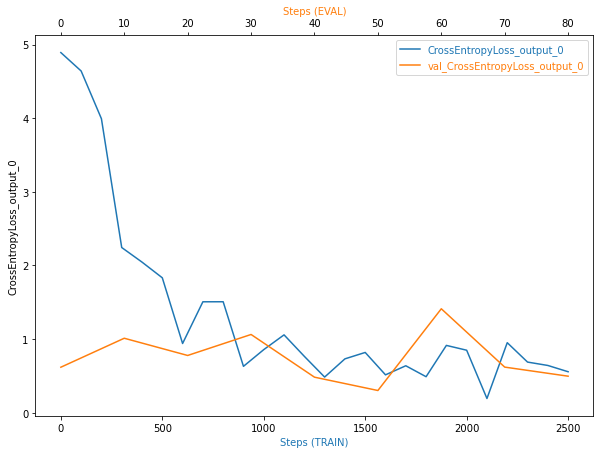

In [25]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

-----------------------------------------------------------------------------------------------------

### Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

Possible issues:
##### 1) Overfitting:
    
    The validation loss significantly increased beyond the training loss between steps `1500 & 2000`. 
    This could indicate the the model started overfitting beyond this point.
    The number of epochs, batch size and step sizes are critical to capturing the debugging information at regular intervals.
    
    A possible resolution to the overfitting problem would be to tweak these values(eg. increase batch size) - such that losses are backpropagated fewer times. Thus, allowing more room for generalization.

##### 2) Unrepresentative Validation Dataset - a possible deduction from the noisy validation loss curve.



-----------------------------------------------------------------------------------------------------
### Display the profiler output
-----------------------------------------------------------------------------------------------------

In [26]:
# Check if profiler processing is complete and reports are available

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-994847135802/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-04-04-46-09-444/profiler-output


Profiler data from system is available


In [27]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

In [28]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-05-04 05:30:21.030 ip-172-16-42-201:16934 INFO metrics_reader_base.py:134] Getting 39 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [29]:
rule_output_path = estimator_debug.output_path + estimator_debug.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-04-04-46-09-444/rule-output


In [30]:
# Download the profiler report output

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-05-04 05:25:38     386428 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-05-04 05:25:38     236458 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-05-04 05:25:33        192 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-05-04 05:25:33        200 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-05-04 05:25:33       1994 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-05-04 05:25:33        127 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-05-04 05:25:33        199 pytorch-training-2022-05-04-04-46-09-444/rule-output/ProfilerReport/profiler-output/profiler-re

In [31]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_debug.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [32]:
profiler_report_name

'ProfilerReport'

In [33]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [34]:
estimator_debug.latest_training_job.job_name

'pytorch-training-2022-05-04-04-46-09-444'

In [35]:
sagemaker_session = sagemaker.session.Session()
sagemaker_session.default_bucket() 

'sagemaker-us-east-1-994847135802'

In [36]:
estimator_debug

-----------------------------------------------------------------------------------------------------
## STEP C - MODEL DEPLOYING

The deployed model's predictor  uses `pretrained_model.py` script to process inferences on the input

-----------------------------------------------------------------------------------------------------


In [37]:
# Predictor class for serializing and deserializing byte array image input

jpeg_serializer = IdentitySerializer("image/jpeg")
json_deserializer = JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        

In [47]:
's3://' + sagemaker_session.default_bucket() +"/"+ latest_job + '/output/model.tar.gz'

's3://sagemaker-us-east-1-994847135802/pytorch-training-2022-05-04-04-46-09-444/output/model.tar.gz'

In [88]:
# Create a model object from pre-trained model

sagemaker_session = sagemaker.session.Session()

latest_job = 'pytorch-training-2022-05-04-04-46-09-444'

model = PyTorchModel(model_data = 's3://' + sagemaker_session.default_bucket() +"/"+ latest_job + '/output/model.tar.gz',
                     role = sagemaker.get_execution_role(),
                     framework_version = '1.8',
                     source_dir="code",
                     entry_point = 'pretrained_model.py',
                     py_version='py3',
                     predictor_cls=ImagePredictor)


In [89]:
# Deploy your model to an endpoint

predictor=model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 


------!

In [90]:
predictor.endpoint_name

'pytorch-inference-2022-05-04-06-49-18-952'

-----------------------------------------------------------------------------------------------------
#### Functions to derive labels and image info

In [92]:
def get_original_label(file):
    ''' function to derive original label of an image from folder name'''
    target_str = 'dataset/dogImages/test/'
    in_pos = file.index(target_str) + len(target_str)
    label = int(file[in_pos:in_pos+3])
    return label

In [93]:
def get_breed(file):
    ''' function to derive dog breed from image file name'''
    target_str = 'dataset/dogImages/test/'
    in_pos = file.index(target_str) + len(target_str)
    next_sep_pos = file.index("/",in_pos)
    breed = file[in_pos+4:next_sep_pos]
    return breed

In [94]:
def get_prediction(predictor, file):
    ''' function to predict labels given dog-image file name and predictor'''
    image_bytes = open(file, 'rb').read()
    response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1  
    return prediction

-----------------------------------------------------------------------------------------------------
## STEP D - INFERENCING ON TEST DATA
-----------------------------------------------------------------------------------------------------

In [104]:
from matplotlib import image
import matplotlib.pyplot as plt

# Sample images for predicting labels using deployed endpoint

test_files = [ 'dataset/dogImages/test/004.Akita/Akita_00262.jpg',
               'dataset/dogImages/test/069.French_bulldog/French_bulldog_04822.jpg',
               'dataset/dogImages/test/014.Basenji/Basenji_00974.jpg',
               'dataset/dogImages/test/057.Dalmatian/Dalmatian_04047.jpg'] 

# Predictions on sample images

predictions = [get_prediction(predictor, file) for file in test_files]


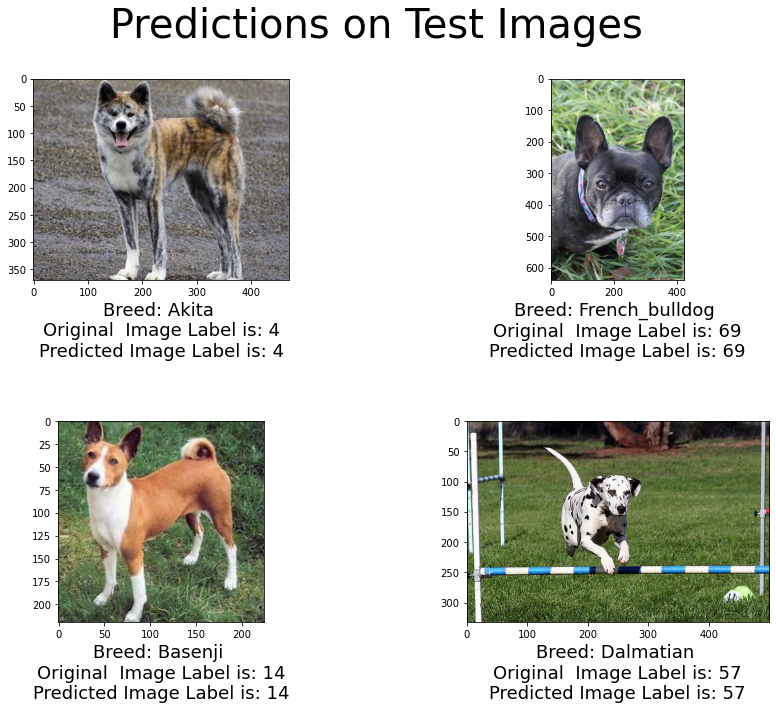

In [112]:
# Load and display image predictions with Matplotlib

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Display the array of pixels as an image
for i, ax in enumerate(fig.axes):
    img = image.imread(test_files[i])
    ax.imshow(img)
    ax.set_xlabel(f"Breed: {get_breed(test_files[i])} \nOriginal  Image Label is: {get_original_label(test_files[i])}"+
                    f"\nPredicted Image Label is: {predictions[i]}", 
                  fontsize=18)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
fig.suptitle("Predictions on Test Images", fontsize=40)
plt.show()

fig.savefig('predictions.jpg')


In [113]:
# Shutdown/delete endpoint once work is done
predictor.delete_endpoint()